### Portfolio assignment <br>

In my previous task I tried to group radio signals data into "Pulsar" and "Not a Pulsar". <br>
One of my proposed ideas was to create a classification algorithm for detecting new incoming signals as pulsars or noise. <br>
In this project I will bring this idea to life by implementing different classification models and choosing the best one at the end. <br>

My goal is to create a machine learning model that would be able sucessfully identify incoming signals from space <br>
as "Pulsars" or "Noise". This will save a lot of time for scientists who are working this Pulsar detection and radio signal processing. <br>
I will use the original dataset and not the one where I created my own clusters. <br>

Now let's have a look at the dataset. <br>
Available here: <br>
https://archive.ics.uci.edu/dataset/372/htru2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

### <b>Initial Data Analysis</b>

In [2]:
df = pd.read_csv("HTRU_2.csv", names=['mean', 'sd', 'excess kurtosis', 'skewness', 
                                      'mean2', 'sd2', 'excess kurtosis2', 'skewness2', 'target'])
df 

,mean,sd,excess kurtosis,skewness,mean2,sd2,excess kurtosis2,skewness2,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


As can be seen there are 8 features, a target variable (0 = "not pulsar", 1 = "pulsar") and almost 18 hundred entries. <br>

Each candidate (row) is described by 8 continuous variables. The first four are simple statistics obtained from the integrated pulse profile<br> (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged <br>
in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR (Dispersion Measure/Signal-to-Noise Ratio) curve. <br>

The original data was like that:

	1. Mean of the integrated profile.
	2. Standard deviation of the integrated profile.
	3. Excess kurtosis of the integrated profile.
	4. Skewness of the integrated profile.
	5. Mean of the DM-SNR curve.
	6. Standard deviation of the DM-SNR curve.
	7. Excess kurtosis of the DM-SNR curve.
	8. Skewness of the DM-SNR curve.

For simplicity I renamed first 4 features of integrated profile into just 'mean', 'sd', 'excess kurtosis' and 'skewness'. <br>
I added a notation '2' for the last 4 features (columns) related to DM-SNR curve. <br>

In [3]:
df.isnull().sum()   # Checking for null values.

mean                0
sd                  0
excess kurtosis     0
skewness            0
mean2               0
sd2                 0
excess kurtosis2    0
skewness2           0
target              0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean              17898 non-null  float64
 1   sd                17898 non-null  float64
 2   excess kurtosis   17898 non-null  float64
 3   skewness          17898 non-null  float64
 4   mean2             17898 non-null  float64
 5   sd2               17898 non-null  float64
 6   excess kurtosis2  17898 non-null  float64
 7   skewness2         17898 non-null  float64
 8   target            17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [5]:
df.describe()

,mean,sd,excess kurtosis,skewness,mean2,sd2,excess kurtosis2,skewness2,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


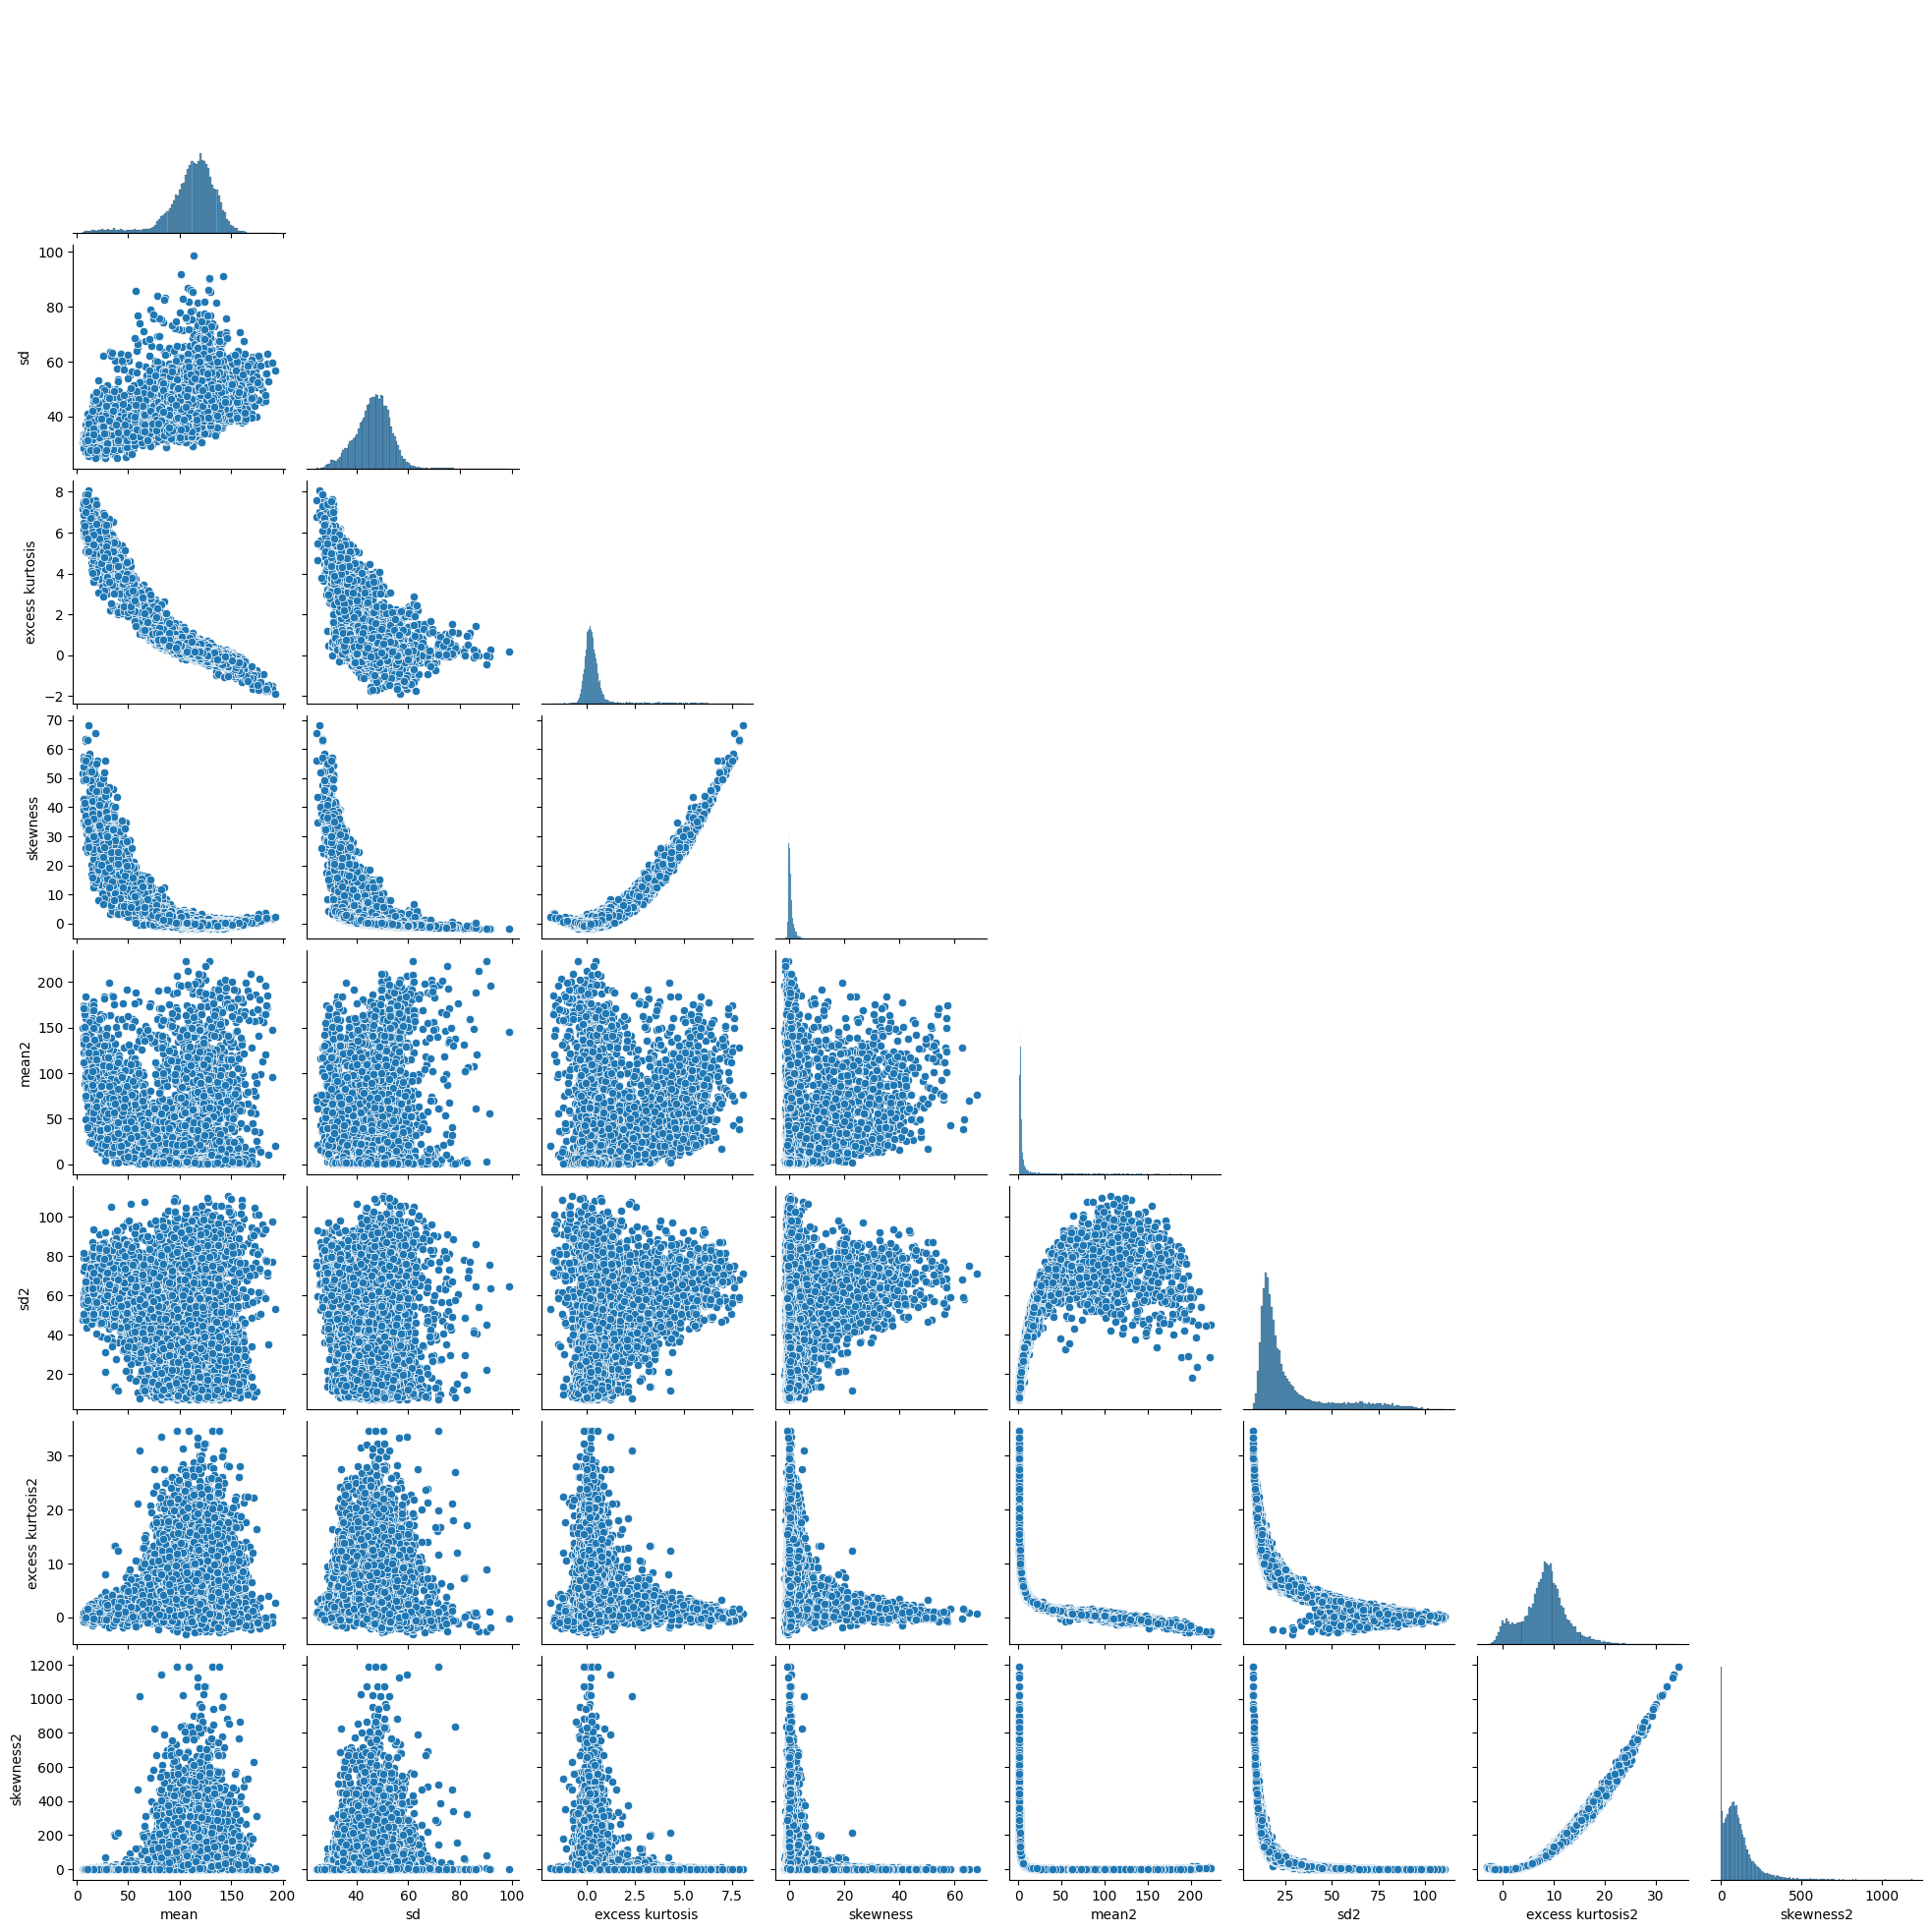

In [6]:
sns.pairplot(df.drop(columns=['target']), corner=True)
plt.show()

In [7]:
X = df.drop(columns=['target'])
X.head(1)   # X data

,mean,sd,excess kurtosis,skewness,mean2,sd2,excess kurtosis2,skewness2
0,140.5625,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225


In [8]:
y = df['target']  # y target data
y.head(2)


0    0
1    0
Name: target, dtype: int64

In [9]:
scaler = StandardScaler()

In [10]:
df['target'].value_counts(normalize=True)

target
0    0.908426
1    0.091574
Name: proportion, dtype: float64

The data is very imbalanced. 90.8% of data belongs to "Noise", while only 9.2 % belongs to "Pulsars". <br>

### <b>A First Impression</b>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=37)
print(len(X_train))
print(len(X_test))
# Splitting the data with stratified distribution (the same class distribution in training and test data),
# which is good for imbalanced dataset.

14318
3580


In [12]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
# Scaling the splitted dataset separately to avoid "data leakage" for our future ML models.

Initializing Support Vector Machine (SVM), Random Forest and a Dummy Classifier on their default configurations to get an overview.

In [13]:
model1 = SVC(random_state=37)                                      # Support Vector Machine (SVM)
model1.fit(X_train, y_train)        
model2 = RandomForestClassifier(random_state=37)                   # Random Forest
model2.fit(X_train, y_train)
dummy3 = DummyClassifier(strategy='stratified', random_state=37)   # Baseline method
dummy3.fit(X_train, y_train)
# Choosing "stratified" strategy for a Baseline model due to imbalanced dataset.

DummyClassifier(random_state=37, strategy='stratified')

In [14]:
print(f"Accuracy of Support Vector Machine is: {model1.score(X_test, y_test):.4f}")
print(f"Accuracy of Random Forest is: {model2.score(X_test, y_test):.4f}")
print(f"Accuracy of Baseline method is: {dummy3.score(X_test, y_test):.4f}")

Accuracy of Support Vector Machine is: 0.9771
Accuracy of Random Forest is: 0.9774
Accuracy of Baseline method is: 0.8257


The Baseline model with 82.6% accuracy significantly underperforms the other two more sophisticated ML models. <br>
Support Vector Machine and Random Forest show almost the same accuracy of 99.7% each. <br>

Now let's initialize models with hyperparameters to tune. <br>

### <b>Nested Cross Validation</b>

In [15]:
model_params = {
    'svm': {
        'model': SVC(random_state=37),
        'params' : {
            'classifier__gamma': ['scale', 'auto'],
            'classifier__C': [0.1, 1, 10, 20],
            'classifier__kernel': ['rbf', 'linear', 'poly']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=37),
        'params' : {
            'classifier__n_estimators': [15, 30, 50, 70, 100, 120],
            'classifier__min_samples_split': [2, 3, 4, 5, 6],
            'classifier__criterion': ['gini', 'entropy', 'log_loss']
        }
    },
    'baseline_model': {
        'model': DummyClassifier(strategy='stratified', random_state=37),
        'params': {}   # No hyperparameters here because there is nothing to tune and also I want to keep it as it is.
    }                  # I still want to run it through nested loop just to make my code more compact and to compare it with other models.
}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)  # these two lines of code could be written directly in
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)  # GridSearchCV and cross_validate methods, but I did it for clarity.

In [16]:
outer_scores = []   
result_grid = []    # The best hyperparameters for each model.

for model_name, mp in model_params.items():
    """The loop runs 3 times. Once for each model: SVM, Random Forest and Baseline model"""
    pipeline = Pipeline([
        ('scaler', StandardScaler()),    # Scaling the splits separately to avoid "data leakage".
        ('classifier', mp['model']) ])   # Supplying the model.
    
    clf = GridSearchCV(pipeline, mp['params'], cv=inner_cv, scoring='recall')      # inner loop
    
    scores = cross_validate(clf, X, y, cv=outer_cv, return_train_score=True,       # outer loop
                            scoring=['balanced_accuracy', 'recall']) 
    outer_scores.append({'model_outer': model_name, 'mean_train_bal': np.mean(scores['train_balanced_accuracy']), 
                         'mean_test_bal': np.mean(scores['test_balanced_accuracy']),  # Saving outer loop's average metrics.
                         'sd_train_bal': np.std(scores['train_balanced_accuracy']),
                         'sd_test_bal': np.std(scores['test_balanced_accuracy']),
                         'mean_train_recall': np.mean(scores['train_recall']),
                         'mean_test_recall': np.mean(scores['test_recall']),
                         'sd_train_recall': np.std(scores['train_recall']),
                         'sd_test_recall': np.std(scores['test_recall'])
                         })

    clf.fit(X, y)   # to see the best hyperparameters of each model
    result_grid.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'standard_deviation': clf.cv_results_['std_test_score'][clf.best_index_]})

85 min it took to perform nested cross validation. <br>

I chose <b>"recall"</b> metric for scoring argument in <b>GridSearchCV</b>. <br>
And I chose <b>"recall"</b> and <b>"balanced accuracy"</b> as my evaluation metrics in <b>cross_validate()</b> method. <br>
The reason is again because of my very imbalanced dataset, where the majority class (0) dominates the minority class (1) with <br>
a ratio of almost 10 to 1. I'm interested in identifying Pulsars (the minority class representing 1) more than identifying noise as noise. <br>

I use StratifiedKFold() method for the same reason of the skewed dataset.

In [17]:
df1 = pd.DataFrame(result_grid,columns=['model', 'best_score', 'best_params', 'standard_deviation'])
df1

,model,best_score,best_params,standard_deviation
0,svm,0.834046,"{'classifier__C': 20, 'classifier__gamma': 'sc...",0.025181
1,random_forest,0.849303,"{'classifier__criterion': 'entropy', 'classifi...",0.022918
2,baseline_model,0.111045,{},0.013590


Above we can see the best <b>"recall"</b> score, hyperparameters and standard deviation for each model. <br>
Below we can see hyperparameters in detail.

In [18]:
print("The best hyperparameters:")
print(f"of SVM are: {df1['best_params'][0]}")
print(f"of Random Forest are: {df1['best_params'][1]}")

The best hyperparameters:
of SVM are: {'classifier__C': 20, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
of Random Forest are: {'classifier__criterion': 'entropy', 'classifier__min_samples_split': 4, 'classifier__n_estimators': 120}


<b>Note*</b> Baseline model doesn't have any hyperparameters. It's there in a table just for comparison. <br>

All in all, Random Forest slightly outperforms SVM in recall score and also has a slightly lower standard deviation at its best than a SVM. <br>
Baseline shows a horrible recall score, despite it had a good accuracy score of 82,6%. <br>

Now, lets' have a look at out "outer loop" of cross_validate method. It has a "balanced accuracy" and a "recall" evaluation metrics. <br>
↓ ↓ ↓

In [19]:
# This scary code only transforms my dataframe in a more appealing format. Maybe there is a faster way to do it.
df2 = pd.DataFrame(outer_scores, columns=['model_outer','mean_train_bal','mean_test_bal', 'sd_train_bal', 'sd_test_bal', 
                                          'mean_train_recall', 'mean_test_recall', 'sd_train_recall', 'sd_test_recall'])
column_mapping = {
    'mean_train_bal': ('balanced_accuracy', 'mean_train'), 'mean_test_bal': ('balanced_accuracy', 'mean_test'),
    'sd_train_bal': ('balanced_accuracy', 'sd_train'), 'sd_test_bal': ('balanced_accuracy', 'sd_test'),
    'mean_train_recall': ('recall', 'mean_train'), 'mean_test_recall': ('recall', 'mean_test'),
    'sd_train_recall': ('recall', 'sd_train'), 'sd_test_recall': ('recall', 'sd_test')
}
new_columns = pd.MultiIndex.from_tuples([column_mapping.get(col, ('model_outer', '')) for col in df2.columns])
df2.columns = new_columns
df2

model_outer balanced_accuracy                                   recall  \
                         mean_train mean_test  sd_train   sd_test mean_train   
0             svm          0.918469  0.911301  0.007339  0.008679   0.841213   
1   random_forest          0.993875  0.921299  0.007406  0.012627   0.987950   
2  baseline_model          0.501651  0.506073  0.002155  0.007484   0.095789   

                                 
  mean_test  sd_train   sd_test  
0  0.827338  0.014101  0.016382  
1  0.849303  0.014460  0.024562  
2  0.111045  0.003951  0.013590

<b>SVM</b> shows very steady results in terms of training and testing scores. It means that the model is perfectly balanced. <br>
<b>Random Forest</b> shows rather higher training score than testing score, especially with recall metric. It can be a sign of overfitting. <br>
Random Forest has a slightly higher standard deviation than SVM, which tells us that RF's performance is more uneven than the one of SVM. <br>
SVM performs more steadily than Random Forest, because its standard deviation is smaller. <br>

As for the Baseline model's performance it's significantly lower than the other two. There is no point of considering this model anymore. <br>

In general, performance of Random Forest and SVM is quite similar. But I will choose <b>Random Forest</b> as my final model. 

### <b>Analysis of the Final Model</b>

Using the final model Random Forest with corresponding hyperparameters I will evaluate its predictions for each class. <br>
0 stands for "Not Pulsar" and 1 stands for "Pulsar". <br>
I will use a regular train test split method that I implemented earlier to get y_predicted values.

In [33]:
final_model = RandomForestClassifier(criterion='entropy', n_estimators=120, min_samples_split=4, random_state=37)
final_model.fit(X_train, y_train)                
y_predicted = final_model.predict(X_test)
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9833    0.9935    0.9884      3252
           1     0.9286    0.8323    0.8778       328

    accuracy                         0.9788      3580
   macro avg     0.9559    0.9129    0.9331      3580
weighted avg     0.9783    0.9788    0.9782      3580



The model predicts "Noise" as noise quite good with 99% chance. Hoever, identifying "Pulsars" as Pulsars gives only 83% score. <br>
Overall precision is high. F1-score is also worse for class 1 just like recall.

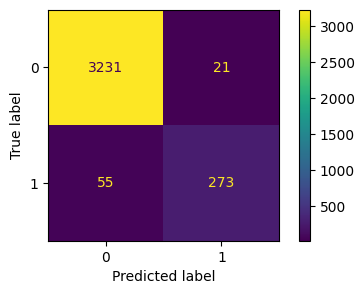

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, ax=ax)   # true values, predicted values.
plt.show()
# Just to get more insights about class accuracy distribution.

### <b>Feature Importance</b>

In [30]:
from sklearn.inspection import permutation_importance
final_model = RandomForestClassifier(criterion='entropy', n_estimators=100, min_samples_split=5, random_state=37)
final_model.fit(X_train, y_train)
perm = permutation_importance(final_model, X_test, y_test, n_repeats=10, scoring='recall', random_state=37)
# Display the feature importances
for i in perm.importances_mean.argsort()[::-1]:
    print(f"{df.columns[i]}: {perm.importances_mean[i]:.4f}")

excess kurtosis: 0.7210
sd2: 0.0372
mean: 0.0314
skewness: 0.0204
sd: 0.0146
mean2: 0.0073
skewness2: -0.0061
excess kurtosis2: -0.0061


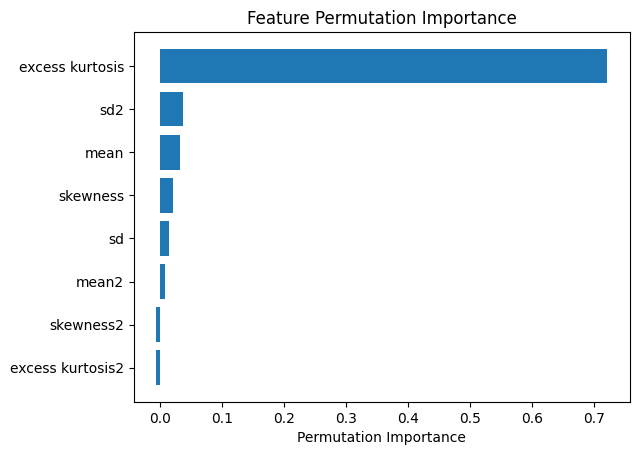

In [31]:
# Visualizing the same data in a horizontal bar plot.
sorted_idx = perm.importances_mean.argsort()   # Sort the features by importance to get the indices.
plt.barh(X.columns[sorted_idx], perm.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Permutation Importance")
plt.show()

The <b>most important feature</b> is "excess kurtosis", meaning that this column has the most influence on the model. <br>

Two columns: "skewness2" and "excess kurtosis2" have negative feature importance. It tells us that the predictions on the shuffled data <br>
are more accurate than the real data. It also means that these features are adding no useful information to the model. <br>
It also implies that if we drop these two columns are model's performance won't change. <br>

Other features: sd2, mean, skewness, sd and mean2 have very low feature importance values which means they also have a very low <br>
impact on the model's performance.

### <b>Conclusion</b> <br>

1. Initial data visualization and data understanding were performed.
2. No data preprocessing was done as the data was already clean.
3. Preliminary results of SVM, Random Forest and Baseline (Dummy Classifier) models were retrieved.
4. Hyperparameters were chosen and tuned during nested cross validation procedure.
5. Train, test score and standard deviation were extracted from the "outer loop" for "balanced accuracy" and "recall" evaluation metrics for each model.
6. All 3 models were compared, in particular SVM and Random Forest.
7. Random Forest was chosen as the final model with "recall" as an evaluation score metric.
8. Analysis of the final model was done in terms of class prediction accuracy using classification report and confusion matrix.
9. Feature importance was carried out to find out that "excess kurtosis" is the most important feature/column in the dataset.

The result of this project is a ML classification algorithm that is able to identify incoming space signal as "Pulsar" or "Noise". <br>
The real noise it identifies with 99% accuracy and real pulsars with 83% accuracy. <br>
This model can be save time for scientists who process these signals. <br>

<b>Limitations</b><br>
I only chose two main algorithms. I chose only 2 evaluation metrics. Other metrics like Receiver Operating Characteristic <br> 
Area Under the Curve (ROC-AUC) and adding weights for classes could also be an option. <br>
Scaling could be done with Normalizer or MinMaxScaler, not just with StandardScaler. <br>
More folds (like 10) could be done during cross validation. <br>

<b>Future Work</b><br>
Since my data is heavily imbalanced some techniques could be used to overcome this issue like: <br>
1. Over sampling minority class using SMOTE.
2. Ensemble different datasets and use majority vote.
3. Adding weights to classes. For example: focal loss.

Other ML models could be used like AdaBoost and Logistic Regression. <br>
Random Forest could get other hyperparameters tunes like max_depth, min_samples_leaf and max_features in order to reduce overfitting. <br>